<a href="https://colab.research.google.com/github/DiegoPincheiraIb/EL4106_Assignments/blob/main/Assignment3/Assignment3_EL4106.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga de datos

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from google.colab import files
from sklearn.preprocessing import StandardScaler
import sys
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


##### -------- Carga de datos: -------


url = 'https://raw.githubusercontent.com/DiegoPincheiraIb/EL4106_Assignments/main/Assignment3/2_HTRU_2.csv'
datos = pd.read_csv(url,names=['mean_prof','std_prof','exkurt_prof','skew_prof','mean_curve','std_curve','exkurt_curve','skew_curve','Class'])
print('Se tiene a continuación los datos importados:')
print(datos.head())

Se tiene a continuación los datos importados:
    mean_prof   std_prof  exkurt_prof  skew_prof  mean_curve  std_curve  exkurt_curve  skew_curve  Class
0  140.562500  55.683782    -0.234571  -0.699648    3.199833  19.110426      7.975532   74.242225      0
1  102.507812  58.882430     0.465318  -0.515088    1.677258  14.860146     10.576487  127.393580      0
2  103.015625  39.341649     0.323328   1.051164    3.121237  21.744669      7.735822   63.171909      0
3  136.750000  57.178449    -0.068415  -0.636238    3.642977  20.959280      6.896499   53.593661      0
4   88.726562  40.672225     0.600866   1.123492    1.178930  11.468720     14.269573  252.567306      0


# P3 - Remuestreo de datos

Se diseña esta función para que, dado un dataframe, una cantidad de datos, y una clase, remuestree los datos (under-sampling) de dicho dataframe, extrayendo la cantidad de datos establecida de dicha clase:

In [ ]:
def Remuestreo(df_input, numero, clase):
  df_obj = df_input.loc[df_input['Class'] == clase].copy()
  output = df_obj.sample(n=numero, random_state=1)  # Se extraen de forma aleatoria la cantidad de datos fijada
  output = output.reset_index(drop=True) # Se reinician los índices
  return output


Se remuestrea los datos correspondientes a la clase 0 del conjunto original a 1639 muestras:

In [ ]:
P3 = Remuestreo(datos, 1639, 0)
print(P3) 

# P4 - Creación de conjuntos de Training, Test, y Validation

In [ ]:
def Union_Datos_1_Datos_0(DataX_1, DataX_2):
  Old_DataX_Set = pd.concat([DataX_1,DataX_2]) # Se crea un conjunto a partir de dos subconjuntos
  copia_Old_DataX_Set = Old_DataX_Set.copy()
  DataX_Set = copia_Old_DataX_Set.sample(frac=1, random_state=1) # Se reordena aleatoriamente el conjunto
  DataX_Set = DataX_Set.reset_index(drop=True)
  return DataX_Set


def Dividir_Conjuntos(DataX,Pctj_Trg,Pctj_Vld_Test):
  corte_trg_set_X = int((len(DataX))*Pctj_Trg) # Cota de corte para 60%
  corte_vld_set_test_set_X = int((len(DataX))*(Pctj_Trg+Pctj_Vld_Test)) # Cota de corte para 20%
  Copia_DataX = DataX.copy()
  Training_Set_X = Copia_DataX.iloc[:corte_trg_set_X] # 60% de los datos pulsar
  Val_Set_X = Copia_DataX.iloc[corte_trg_set_X:corte_vld_set_test_set_X] # 20% de los datos pulsar
  Test_Set_X = Copia_DataX.iloc[corte_vld_set_test_set_X:] # 20% restante de los datos pulsar
  return Training_Set_X, Val_Set_X, Test_Set_X

def Conjuntos(DataX,Pctj_Trg,Pctj_Vld_Test, numero):
  # Aquí se separan los datos en muestras positivas y negativas
  Data_1 = Remuestreo(DataX, numero, 1) # Esto incluyen reordenamiento aleatorio
  Data_0 = Remuestreo(DataX, numero, 0) # Esto incluyen reordenamiento aleatorio
  # 1era parte: Datos Pulsar
  Training_Set_1, Val_Set_1, Test_Set_1 = Dividir_Conjuntos(Data_1,Pctj_Trg,Pctj_Vld_Test)
  Training_Set_0, Val_Set_0, Test_Set_0 = Dividir_Conjuntos(Data_0,Pctj_Trg,Pctj_Vld_Test)
  # ------------------------
  # 3era parte: Crear los conjuntos:
  ## a) Training Set:
  Training_Set = Union_Datos_1_Datos_0(Training_Set_1, Training_Set_0)
  # ------------------------
  ## b) Validation Set:
  Validation_Set = Union_Datos_1_Datos_0(Val_Set_1, Val_Set_0)
  # ------------------------
  ## c) Test Set:
  Test_Set = Union_Datos_1_Datos_0(Test_Set_1, Test_Set_0)
  # ------------------------
  return Training_Set, Test_Set, Validation_Set

Se crean los conjuntos de **Entrenamiento, Prueba y Validación**, con el 60% de los datos originales destinados al conjunto de entrenamiento, un 20% para el conjunto de prueba, y el porcentaje restante (20%) para el conjunto de validación:

In [ ]:
Training_Set, Test_Set, Validation_Set = Conjuntos(datos,0.6,0.2, 1639)

print('Conjunto de entrenamiento:')
print(Training_Set)
print('Conjunto de prueba:')
print(Test_Set)
print('Conjunto de validación:')
print(Validation_Set)

# P5 - Kernel Lineal

Se diseña una función que separa los conjuntos en 2: Un Vector X, el cual tiene los valores de las características de cada dato, y un vector Y, el cual tiene la información de la clase de cada dato:

In [ ]:
def VectoresX_Y(Conjunto):
  Copia_Conjunto = Conjunto.copy() # Se copia el conjunto objetivo
  Clases_Conjunto = Copia_Conjunto.iloc[:, -1] # Se extrae la info de las clases del conjunto
  Clases_Conjunto_NP = Clases_Conjunto.values # Se convierten las clases a Numpy
  Caract_Conjunto = Copia_Conjunto.iloc[:, 0:7] # Se extrae la info de las características
  Caract_Conjunto_NP = Caract_Conjunto.values # Se convierten las características a Numpy:
  return Caract_Conjunto_NP, Clases_Conjunto_NP

Se aplica esta función a los conjuntos de Entrenamiento, Prueba y Validación.

In [ ]:
X_Training_0, Y_Training = VectoresX_Y(Training_Set)
X_Test_0, Y_Test = VectoresX_Y(Test_Set)
X_Validation_0, Y_Validation = VectoresX_Y(Validation_Set)

Se procede a crear un estandarizador de datos, el cual se entrena en función del conjunto de entrenamiento:

In [ ]:
def Estandarizacion(X_Entrenamiento, X_Prueba, X_Validacion):
  Estandarizador = StandardScaler().fit(X_Entrenamiento) # Se crea el estandarizador
  # Se aplica el estandarizador:
  Training_Set_Caract_Est = Estandarizador.transform(X_Entrenamiento) # Se aplica el Estandarizador al Conjunto de Training
  Test_Set_Caract_Est = Estandarizador.transform(X_Prueba) # Se aplica el Estandarizador al Conjunto de Validacion
  Validation_Set_Caract_Est = Estandarizador.transform(X_Validacion) # Se aplica el Estandarizador al Conjunto de Test
  return Training_Set_Caract_Est, Test_Set_Caract_Est, Validation_Set_Caract_Est

Se divide los conjuntos en características y clases, y se estandarizan:

In [ ]:
X_Training, X_Test, X_Validation = Estandarizacion(X_Training_0, X_Test_0, X_Validation_0)

Aquí se crea un constructor de un clasificador general:

In [ ]:
def Constructor_Clasificador(Tipo_Kernel, Probabilidad, N_Folds, Parametros):
  Clasificador_SVM = svm.SVC(kernel=Tipo_Kernel, probability=Probabilidad)
  Clasificador_Optimo = GridSearchCV(estimator=Clasificador_SVM, cv=N_Folds, param_grid= Parametros )
  return Clasificador_Optimo

En las siguientes lineas se aplica el clasificador:

In [ ]:
Valores_C = {'C': [0.01,0.1,1,10,100]}
Clasificador_Lineal = Constructor_Clasificador('linear', False, 5, Valores_C)
Clasificador_Lineal.fit(X_Training, Y_Training) # Entrenamiento del clasificador

# P6 - Matriz de Confusión

Se crea una función que retorna una matriz de confusión dado los siguientes elementos: un clasificador ya entrenado, y vectores X e Y pertenecientes al conjunto de validación.

In [ ]:
def Matriz_Confusion(X_Val, Y_Val,Clasificador):
  Y_Predict_Val = Clasificador.predict(X_Val)
  return metrics.confusion_matrix(Y_Val, Y_Predict_Val)

Se aplica la función anterior al conjunto de validación, utilizando el clasificador lineal entrenado en la P5

In [ ]:
Matriz_Confusion(X_Validation, Y_Validation, Clasificador_Lineal)

array([[326,   2],
       [ 28, 300]])

# P7 - Curva ROC

Se crea una función que, dado un conjunto de validación separado en características y clases, y un clasificador ya entrenado, entrega una curva ROC (omitible si se añade un booleano ``False''), y además el área bajo la curva:


In [ ]:
def Generador_ROC_AUC(X_Val, Y_Val, Clasificador, Plot = True):
  Score = Clasificador.decision_function(X_Val)
  TFP, TVP, _ = metrics.roc_curve(Y_Val, Score)
  AUC_ROC = metrics.auc(TFP, TVP)
  #metrics.auc
  if Plot:
    plt.figure(figsize=(7, 6))
    plt.plot(TFP, TVP, color='blue', label='ROC (AUC = %0.4f)' % AUC_ROC)
    plt.legend(loc='best')
    plt.title("Curva ROC")
    plt.xlabel("TFP: Tasa de Falsos Positivos")
    plt.ylabel("TVP: Tasa de Verdaderos Positivos")
    plt.show()
  return AUC_ROC

Curva ROC para el Clasificador Lineal implementado en P5:

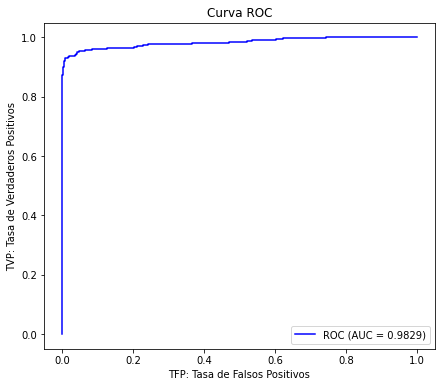

Área bajo la curva para el clasificador lineal:  0.9829063801308745


In [ ]:
ROC_AUC_Lineal = Generador_ROC_AUC(X_Validation, Y_Validation, Clasificador_Lineal)
print('Área bajo la curva para el clasificador lineal: ',ROC_AUC_Lineal)

# P8 - Curva Precision Recall

Se genera una función que, dado un conjunto de validación separado en características y clases, y un clasificador entrenado, entregue un gráfico de la curva Precision-Recall (omitible si, en conjunto con los otros parámetros, se añade un booleano ``False''), en conjunto con la precisión promedio:


In [ ]:
def Generador_PRC(X_Val, Y_Val, Clasificador, Plot = True):
  Score = Clasificador.decision_function(X_Val)
  PR, RC, thres = metrics.precision_recall_curve(Y_Val, Score)
  AP = metrics.average_precision_score(Y_Val, Score)
  if Plot:
    plt.figure(figsize=(7, 6))
    plt.plot(RC, PR, label='PRC (AP = %0.4f)' % AP)
    plt.legend(loc='best')
    plt.title("Curva Precision v/s Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()
  return AP

Se evalúa lo anterior con el conjunto de validación y el clasificador lineal de la parte 5:

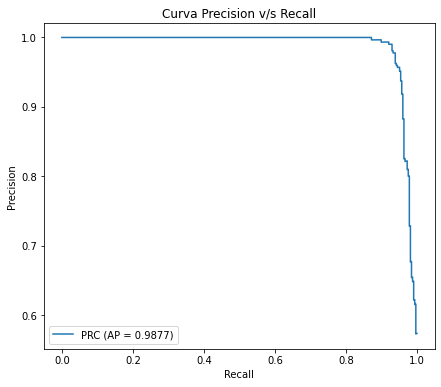

Average Precision de clasificador lineal: 0.987670673208853


In [ ]:
PRC_Lineal = Generador_PRC(X_Validation, Y_Validation, Clasificador_Lineal)
print('Average Precision de clasificador lineal:', PRC_Lineal)

# P9 - Kernel RBF

**Kernel RBF:**

Construcción y entrenamiento del clasificador:

In [ ]:
Valores_C = [0.01,0.1,1,10,100]
Sigmas = [0.001, 0.01, 0.1, 1]
Parametros = {'C': Valores_C, 'gamma' : Sigmas}
Clasificador_RBF = Constructor_Clasificador('rbf', False, 5, Parametros)
Clasificador_RBF.fit(X_Training, Y_Training) # Entrenamiento del clasificador

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Matriz de confusión:

In [ ]:
Matriz_Confusion(X_Validation, Y_Validation, Clasificador_RBF)

array([[323,   5],
       [ 27, 301]])

Generador de Curva ROC y Área bajo la curva:

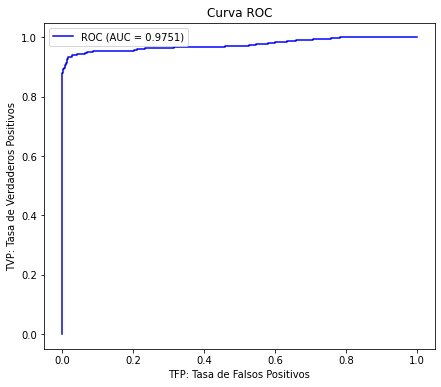

Área bajo la curva de clasificador RBF : 0.9750799375371803


In [ ]:
ROC_RBF = Generador_ROC_AUC(X_Validation, Y_Validation, Clasificador_RBF)
print('Área bajo la curva de clasificador RBF :',ROC_RBF)

Curva Precision Recall:

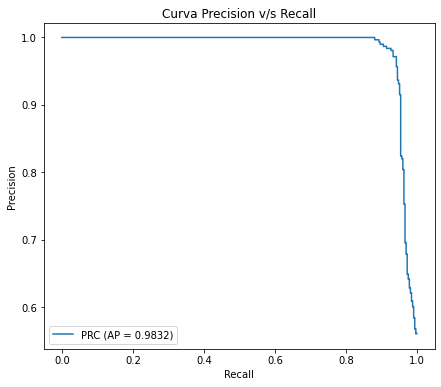

Precisión promedio de clasificador RBF: 0.9832341633539389


In [ ]:
PRC_RBF = Generador_PRC(X_Validation, Y_Validation, Clasificador_RBF)
print('Precisión promedio de clasificador RBF:',PRC_RBF)

# P9 - Kernel Polinomial

**Kernel Polinomial:**

Construcción y entrenamiento del clasificador:

In [ ]:
Valores_C = [0.01,0.1,1,10,100]
Grados = [2, 3]
Parametros = {'C': Valores_C, 'degree' : Grados}
Clasificador_Poly = Constructor_Clasificador('poly', False, 5, Parametros)
Clasificador_Poly.fit(X_Training, Y_Training) # Entrenamiento del clasificador

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='poly', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Matriz de confusión:

In [ ]:
Matriz_Confusion(X_Validation, Y_Validation, Clasificador_Poly)

array([[326,   2],
       [ 28, 300]])

Generador de Curva ROC y Área bajo la curva:

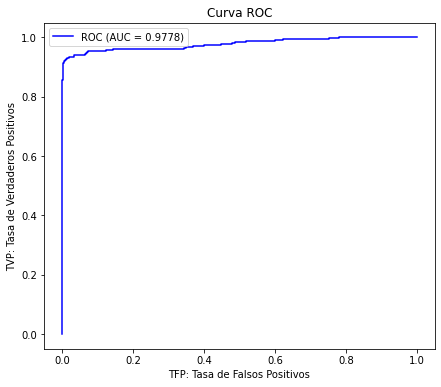

Área bajo la curva de clasificador Polinomial : 0.9777848007138608


In [ ]:
ROC_Poly = Generador_ROC_AUC(X_Validation, Y_Validation, Clasificador_Poly)
print('Área bajo la curva de clasificador Polinomial :',ROC_Poly)

Curva Precision Recall:

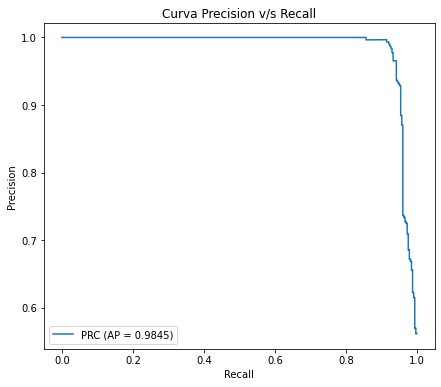

Precisión promedio de clasificador Polinomial: 0.9845325305883483


In [ ]:
PRC_Poly = Generador_PRC(X_Validation, Y_Validation, Clasificador_Poly)
print('Precisión promedio de clasificador Polinomial:',PRC_Poly)

# P10 - Mejor Clasificador

Se observan los desempeños de los clasificadores de acuerdo a las métricas generadas en la P6, P7, y P8:

In [ ]:
Poly_MC = Matriz_Confusion(X_Validation, Y_Validation, Clasificador_Poly)
RBF_MC = Matriz_Confusion(X_Validation, Y_Validation, Clasificador_RBF)
Lineal_MC = Matriz_Confusion(X_Validation, Y_Validation, Clasificador_Lineal)
print('Matriz de confusión de clasificador Polinomial:')
print(Poly_MC)
print('Matriz de confusión de clasificador RBF:')
print(RBF_MC )
print('Matriz de confusión de clasificador Lineal:')
print(Lineal_MC )
print('-------------------------------')
Poly_PRC = Generador_PRC(X_Validation, Y_Validation, Clasificador_Poly, False)
RBF_PRC = Generador_PRC(X_Validation, Y_Validation, Clasificador_RBF, False)
Lineal_PRC = Generador_PRC(X_Validation, Y_Validation, Clasificador_Lineal, False)
print('Precisión promedio de clasificador Polinomial:',Poly_PRC)
print('Precisión promedio de clasificador RBF:',RBF_PRC)
print('Precisión promedio de clasificador Lineal:',Lineal_PRC)
print('-------------------------------')
Poly_ROC = Generador_ROC_AUC(X_Validation, Y_Validation, Clasificador_Poly, False)
RBF_ROC = Generador_ROC_AUC(X_Validation, Y_Validation, Clasificador_RBF, False)
Lineal_ROC = Generador_ROC_AUC(X_Validation, Y_Validation, Clasificador_Lineal, False)
print('Área bajo la curva de clasificador Polinomial :',Poly_ROC)
print('Área bajo la curva de clasificador RBF:',RBF_ROC)
print('Área bajo la curva de clasificador Lineal:',Lineal_ROC)
print('-------------------------------')

Matriz de confusión de clasificador Polinomial:
[[326   2]
 [ 28 300]]
Matriz de confusión de clasificador RBF:
[[323   5]
 [ 27 301]]
Matriz de confusión de clasificador Lineal:
[[326   2]
 [ 28 300]]
-------------------------------
Precisión promedio de clasificador Polinomial: 0.9845325305883483
Precisión promedio de clasificador RBF: 0.9832341633539389
Precisión promedio de clasificador Lineal: 0.987670673208853
-------------------------------
Área bajo la curva de clasificador Polinomial : 0.9777848007138608
Área bajo la curva de clasificador RBF: 0.9750799375371803
Área bajo la curva de clasificador Lineal: 0.9829063801308745
-------------------------------


De acuerdo a los resultados anteriores, el **clasificador Lineal** resulta ser el mejor clasificador, por tener mayor área bajo la curva y precisión promedio por sobre los otros dos clasificadores. Por otra parte, este tiene la misma matriz de confusión que el clasificador polinomial, y ambas matrices son mejores que la matriz generada por el clasificador RBF.

In [ ]:
Y_Predict = Clasificador_Lineal.predict(X_Test) # Pruebo el clasificador con conjunto Test
print("Accuracy:",metrics.accuracy_score(Y_Test, Y_Predict)) # Mido la exactitud

Accuracy: 0.9405487804878049
